# Подготовка библиотек

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-u2arwnsi
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-u2arwnsi
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a09319553fd73de7152ed11e3ed56c72f35a91af_-py3-none-any.whl size=299301 sha256=587a2c6f9e327d68e1770fd78e6247d1545d8d0da7fd66cd3613e6599d975102
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qoyhmgo/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt

# Функции для визуализации

In [3]:
def display(display_list):
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteEHV08K/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteEHV08K/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  input_mask = tf.math.round(input_mask)
  return input_image, input_mask

def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = dataset['train'].map(load_image_train)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BUFFER_SIZE)
test_dataset = test.batch(BATCH_SIZE)

sample_image, sample_mask = next(iter(train.take(1)))

In [9]:
print(TRAIN_LENGTH, info.splits['test'].num_examples)

3680 3669


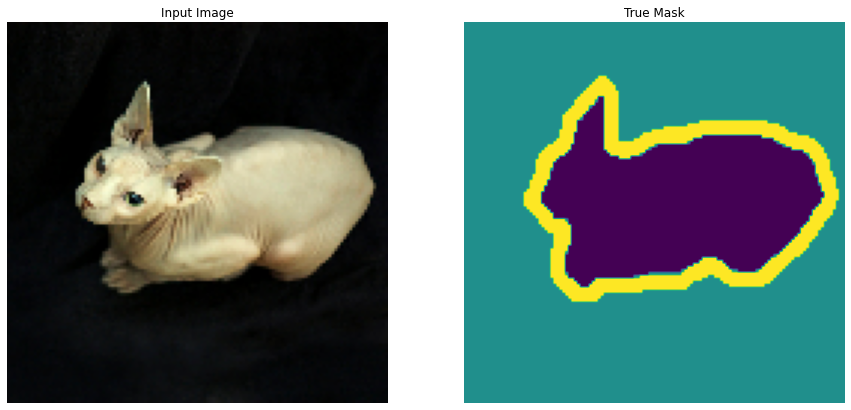

In [10]:
display([sample_image, sample_mask])


In [11]:
tf.unique(tf.reshape(sample_mask, -1))

Unique(y=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 0.], dtype=float32)>, idx=<tf.Tensor: shape=(16384,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

# Модель

In [14]:
tf.random.set_seed(0)

Encoder (слои из преобученной модели MobileNetV2)

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


Decoder

In [16]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')
]

In [18]:
def resolution_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                         padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

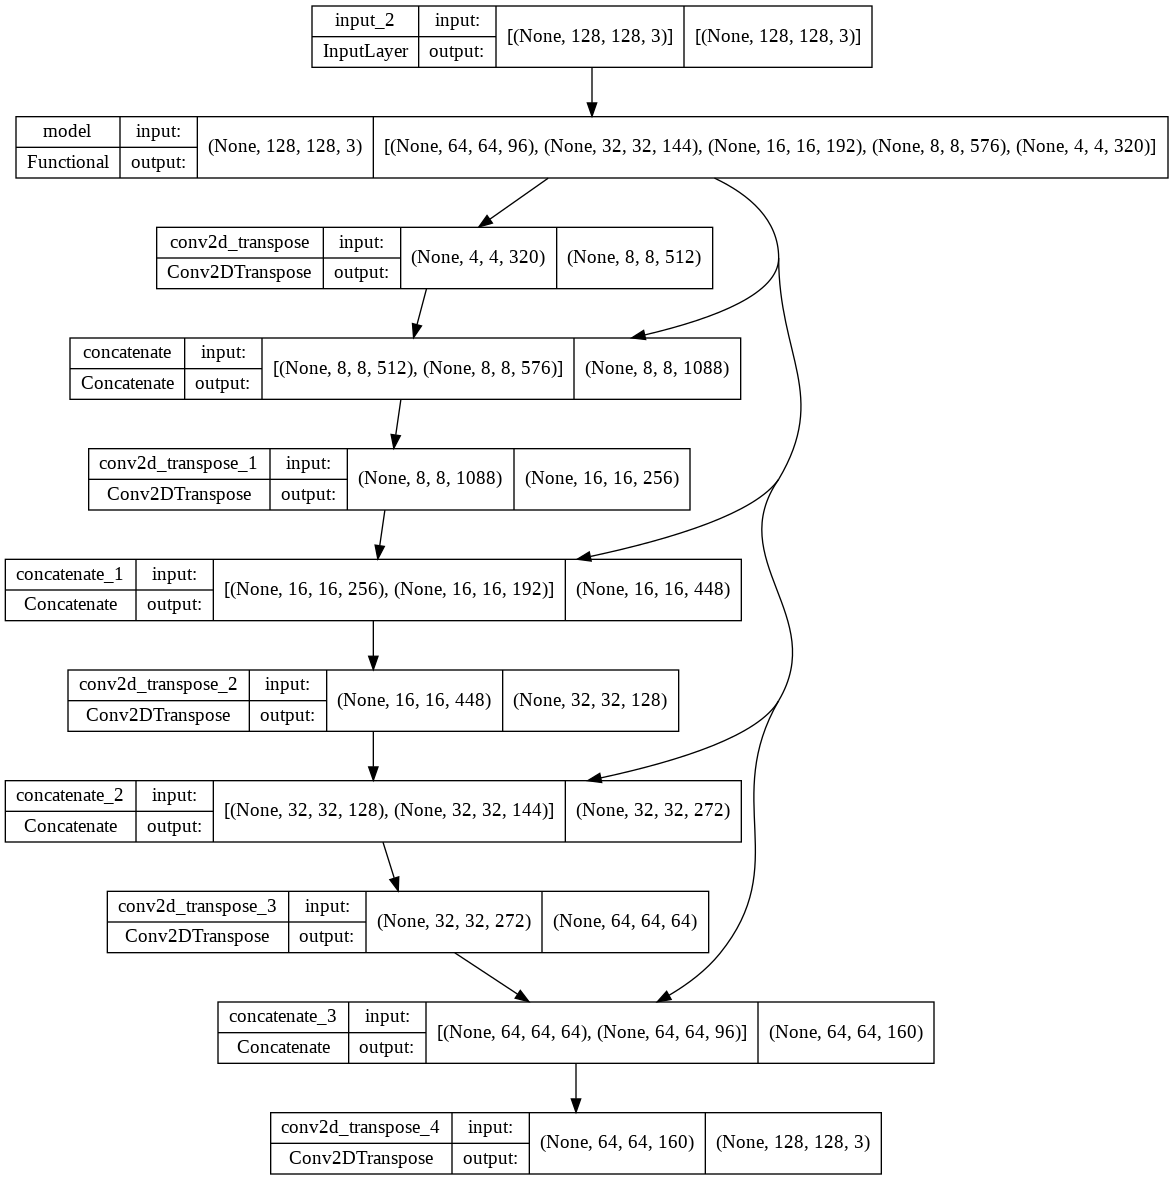

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

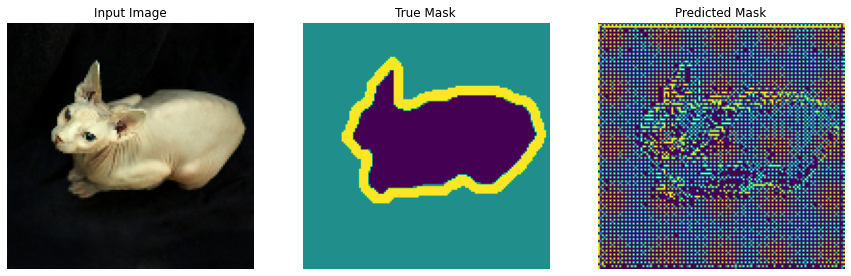

In [21]:
show_predictions(model)

# Обучение

Epoch 1/10
115/115 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7947

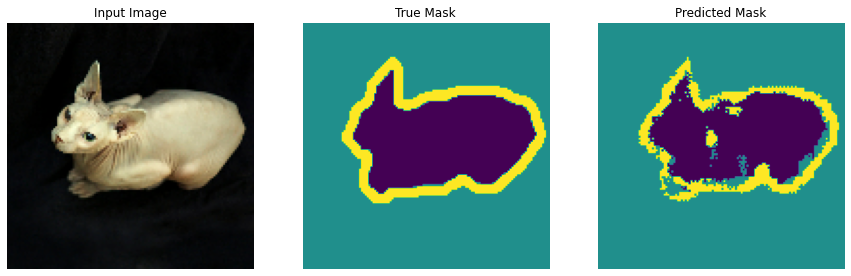


Sample Prediction after epoch 1

115/115 [==============================] - 25s 170ms/step - loss: 0.5042 - accuracy: 0.7947 - val_loss: 0.3511 - val_accuracy: 0.8654
Epoch 2/10
115/115 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8785

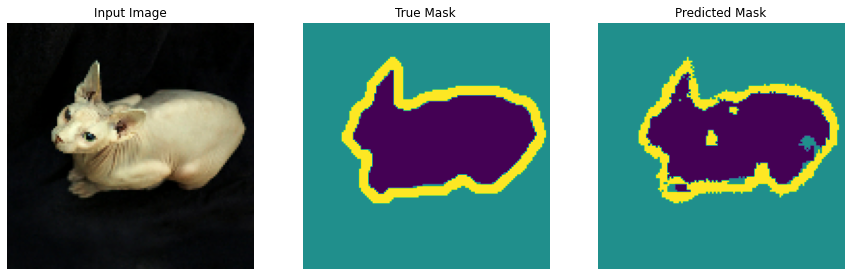


Sample Prediction after epoch 2

115/115 [==============================] - 16s 141ms/step - loss: 0.3162 - accuracy: 0.8785 - val_loss: 0.3092 - val_accuracy: 0.8823
Epoch 3/10
115/115 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.8879

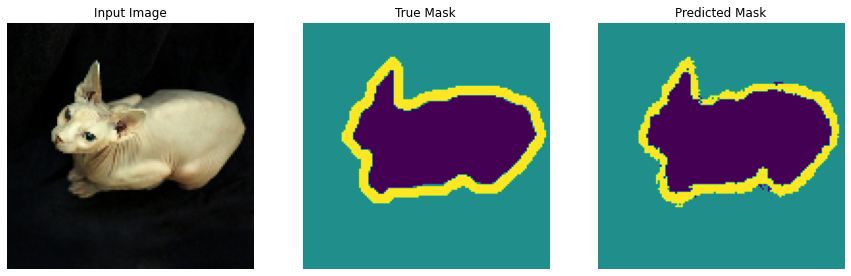


Sample Prediction after epoch 3

115/115 [==============================] - 16s 143ms/step - loss: 0.2898 - accuracy: 0.8879 - val_loss: 0.2972 - val_accuracy: 0.8882
Epoch 4/10
115/115 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.8930

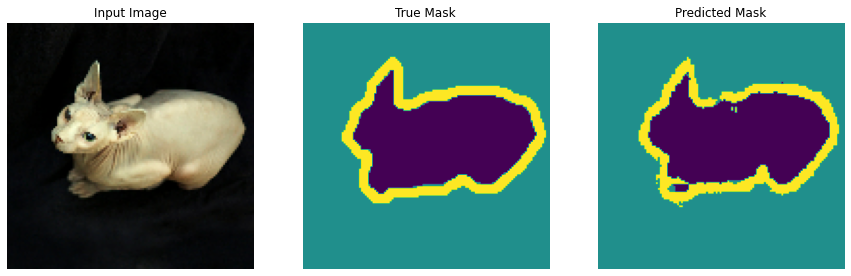


Sample Prediction after epoch 4

115/115 [==============================] - 16s 143ms/step - loss: 0.2763 - accuracy: 0.8930 - val_loss: 0.2897 - val_accuracy: 0.8905
Epoch 5/10
115/115 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8977

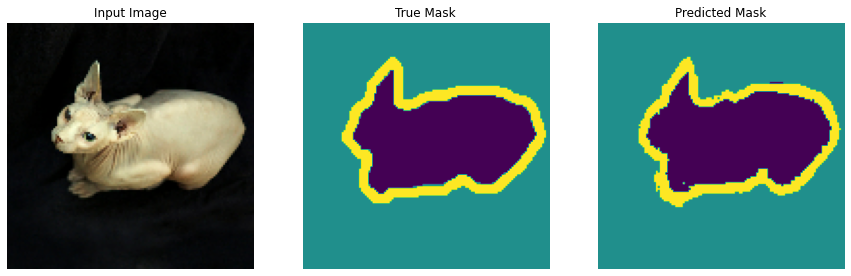


Sample Prediction after epoch 5

115/115 [==============================] - 17s 146ms/step - loss: 0.2637 - accuracy: 0.8977 - val_loss: 0.2884 - val_accuracy: 0.8920
Epoch 6/10
115/115 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.9019

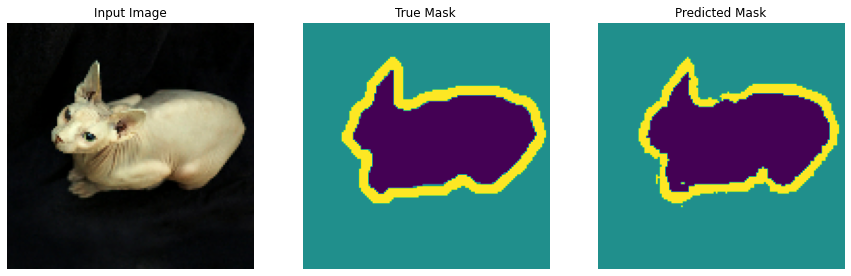


Sample Prediction after epoch 6

115/115 [==============================] - 16s 143ms/step - loss: 0.2519 - accuracy: 0.9019 - val_loss: 0.2779 - val_accuracy: 0.8963
Epoch 7/10
115/115 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9053

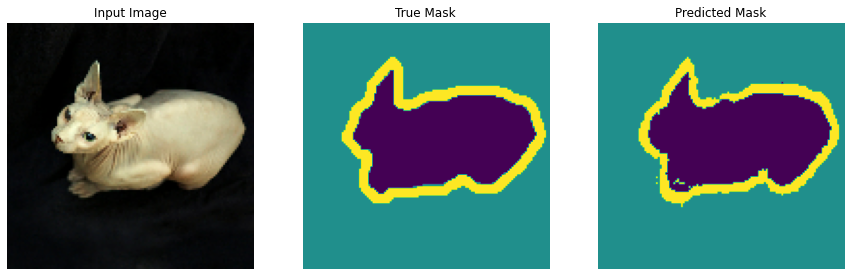


Sample Prediction after epoch 7

115/115 [==============================] - 17s 144ms/step - loss: 0.2426 - accuracy: 0.9053 - val_loss: 0.2766 - val_accuracy: 0.8973
Epoch 8/10
115/115 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9077

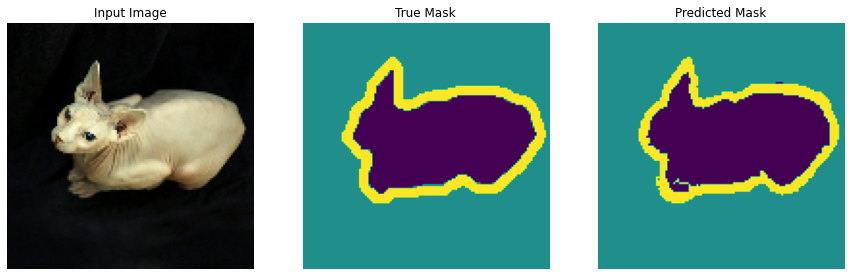


Sample Prediction after epoch 8

115/115 [==============================] - 16s 144ms/step - loss: 0.2367 - accuracy: 0.9077 - val_loss: 0.2717 - val_accuracy: 0.8987
Epoch 9/10
115/115 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9121

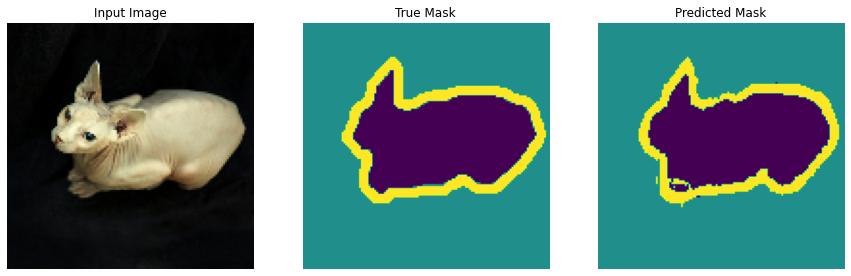


Sample Prediction after epoch 9

115/115 [==============================] - 16s 143ms/step - loss: 0.2244 - accuracy: 0.9121 - val_loss: 0.2803 - val_accuracy: 0.8979
Epoch 10/10
115/115 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9134

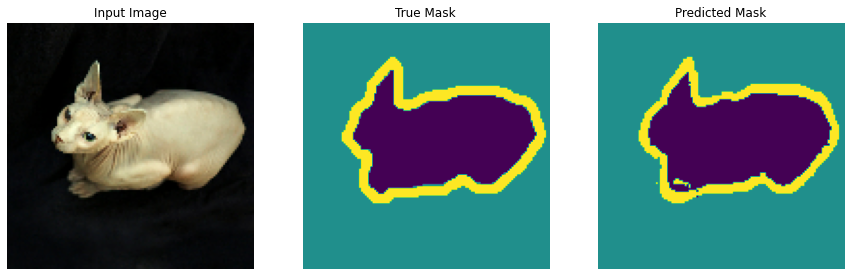


Sample Prediction after epoch 10

115/115 [==============================] - 17s 144ms/step - loss: 0.2206 - accuracy: 0.9134 - val_loss: 0.2807 - val_accuracy: 0.8980


In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 10 # увеличьте при необходимости

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

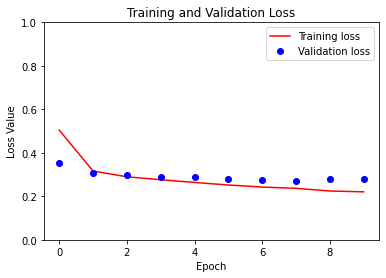

In [23]:
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

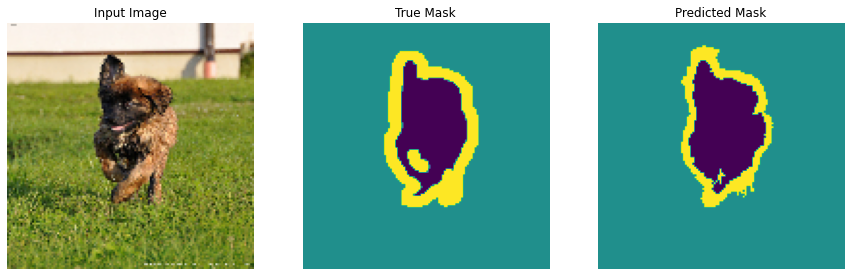

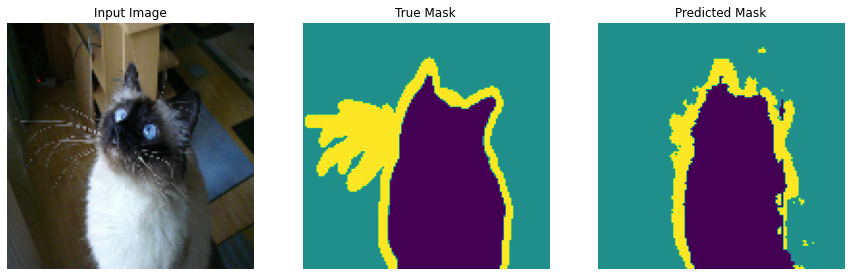

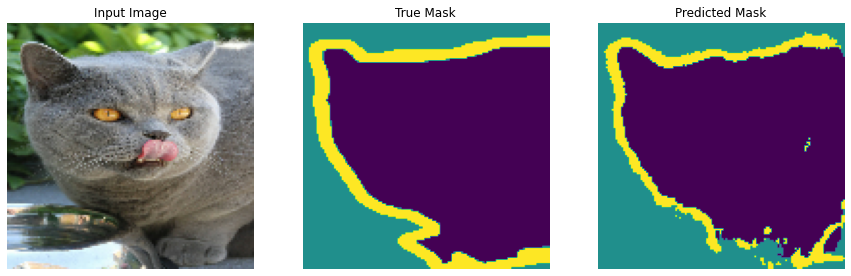

In [24]:
show_predictions(model, test_dataset, 3)